In [18]:
%pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


# New Section

In [19]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = xm.xla_device()

In [20]:
from collections import Counter, defaultdict

import torch
from torch.utils.data import Dataset

# Give credit

class CharacterDataset(Dataset):
    """Custom dataset.

    Parameters
    ----------
    text : str
        Input text that will be used to create the entire database.

    window_size : int
        Number of characters to use as input features.

    vocab_size : int
        Number of characters in the vocabulary. Note that the last character
        is always reserved for a special "~" out-of-vocabulary character.

    Attributes
    ----------
    ch2ix : defaultdict
        Mapping from the character to the position of that character in the
        vocabulary. Note that all characters that are not in the vocabulary
        will get mapped into the index `vocab_size - 1`.

    ix2ch : dict
        Mapping from the character position in the vocabulary to the actual
        character.

    vocabulary : list
        List of all characters. `len(vocabulary) == vocab_size`.
    """
    def __init__(self, text, window_size=1):
        text = " ".join(text.split())
        vocab_size = len(sorted(list(set(text))))

        self.vocab_size = vocab_size
        self.text = text
        self.window_size = window_size
        self.ch2ix = defaultdict(lambda: vocab_size - 1)

        most_common_ch2ix = {
            x[0]: i
            for i, x in enumerate(Counter(self.text).most_common()[: (vocab_size - 1)])
        }
        self.ch2ix.update(most_common_ch2ix)
        self.ch2ix["~"] = vocab_size - 1

        self.ix2ch = {v: k for k, v in self.ch2ix.items()}
        self.vocabulary = [self.ix2ch[i] for i in range(vocab_size)]

    def __len__(self):
        return len(self.text) - self.window_size

    def __getitem__(self, ix):
        X = torch.LongTensor(
            [self.ch2ix[c] for c in self.text[ix : ix + self.window_size]]
        )
        Y = torch.LongTensor(
            [self.ch2ix[c] for c in self.text[ix + 1 : ix + self.window_size + 1]]
        )

        return X, Y

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(device)

def generate_causal_mask(sequence_length):
    # Create an upper triangular matrix of shape (sequence_length, sequence_length)
    mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)
    
    # Convert the mask to a boolean tensor
    mask = mask.to(torch.bool).to(device)
    
    return mask


class DecoderBlock(nn.Module):
    def __init__(self, d_model, context_length, num_heads, dropout=0.1):
        super().__init__()

        self.self_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )

        self.layer_norm2 = nn.LayerNorm(d_model)

        self.mask = generate_causal_mask(context_length)
        
    def forward(self, x):
        # x: input tensor of shape (batch_size, sequence_length, d_model)
        # mask: tensor of shape (batch_size, sequence_length, sequence_length)
        norm = self.layer_norm1(x)

        attn_output, _ = self.self_attention(norm, norm, norm, attn_mask=self.mask)

        x = x + attn_output
        x = x + self.feed_forward(self.layer_norm2(x))

        return x
    
class Decoder(nn.Module):
    def __init__(
        self,
        d_model,
        context_length,
        num_heads,
        num_layers,
        dropout = 0.1):
        super().__init__()

        decoders = [DecoderBlock(d_model, context_length, num_heads, dropout=dropout) for _ in range(num_layers) ]

        self.decoders = nn.Sequential(*decoders)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        x):
        """
        :param x: (batch_size, sequence_length, d_model)
        """

        return self.norm(self.decoders(x))



class Parrot(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        context_size,
        n_heads = 8,
        n_layers = 2):
        super().__init__()


        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Create positional embeddings
        self.positional_embeddings = positionalencoding1d(embedding_dim, context_size)

        # Decoder Layers
        self.decoder = Decoder(embedding_dim, context_size, n_heads, n_layers)

        # Create a dense layer mapping to vocab_size outputs
        # Each neuron will correspond to the probability
        # of a character being the next character in the sequence
        self.dense = nn.Linear(embedding_dim, vocab_size)

        # Store the parameters
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size

        # Initialize the weights
        self.apply(self._init_weights)

        total_params = sum(
	        param.numel() for param in self.parameters()
        )

        print(f"Model size: {total_params / 1000} kParams")


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(
        self,
        tokens,
        targets = None):
        """
        :param tokens: (b, n, d)
        :param targets: (b, n, v)
        """

        # Generate embeddings
        embeddings = self.embedding(tokens)  # (batch_size, sequence_length, embedding_dim)

        #if self.positional_embeddings.size(dim=0) == embeddings.size(dim=1):
        positional_embeddings = self.positional_embeddings
        #elif self.positional_embeddings.size(dim=0) > embeddings.size(dim=1):
        #    emb_sz = embeddings.size(dim=1)
        #    positional_embeddings = self.positional_embeddings[:emb_sz, :]
        #else:
        #    emb_sz = self.positional_embeddings.size(dim=0)
        #    positional_embeddings = self.positional_embeddings
        #    embeddings = embeddings[:, -emb_sz:, :]

        # Add position to the embeddings
        embeddings_with_positions = embeddings + positional_embeddings  # (batch_size, sequence_length, embedding_dim)

        # Run the embeddings through the decoder blocks
        decoded = self.decoder(embeddings_with_positions)

        # Run the output of the decoder blocks through a linear layer
        # to map to vocab_size outputs
        logits = self.dense(decoded)  # (batch_size, sequence_length, vocab_size)

        # Normalize the output into a probability distribution
        # over the vocabulary
        #logits = F.softmax(logits, -1)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            loss_logits = logits.view(B*T, C)
            loss_targets = targets.view(B*T)

            loss = F.cross_entropy(loss_logits, loss_targets)

        return logits, loss

    
    
    @torch.no_grad()
    def generate(
        self,
        tokens: torch.Tensor,
        number_of_tokens: int,
        temperature: int = 0.8,
        top_k: int = None):
        """
        Takes a (b, t) tensor of tokens and generates number_of_tokens tokens
        """
        for _ in range(number_of_tokens):
            token_size = tokens.size(-1)

            if token_size == self.context_size:
                tokens_trimmed = tokens
            elif token_size < self.context_size:
                eoi = self.vocab_size - 1
                tokens_trimmed = F.pad(tokens, pad=(0, self.context_size - token_size), value=eoi)
            else:
                tokens_trimmed = tokens[:, -self.context_size:]

            context_size = min(token_size, self.context_size)

            # Put the tokens through the model to get the logits
            logits, _ = self.forward(tokens_trimmed)

            # Take the last token from the logits and apply the temperature
            logits = logits[:, context_size-1, :] / temperature

            # Optionally apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Reapply a softmax
            probs = F.softmax(logits, -1)

            # Sample from the distribution
            token_next = torch.multinomial(probs, num_samples=1)

            tokens = torch.cat((tokens, token_next), dim=-1)

        return tokens


# String -> Embeddings -> Positional Embeddings -> Transformer -> Dense -> Softmax -> Next Char
#
#

Model size: 1607.249 kParams


100%|██████████| 3077/3077 [07:21<00:00,  6.96it/s]


Epoch: 0, validate_loss=1.949


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


I hope it works which he will he wears his speed and heaven's learning days, And be so lose invitous, a schalf our a


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

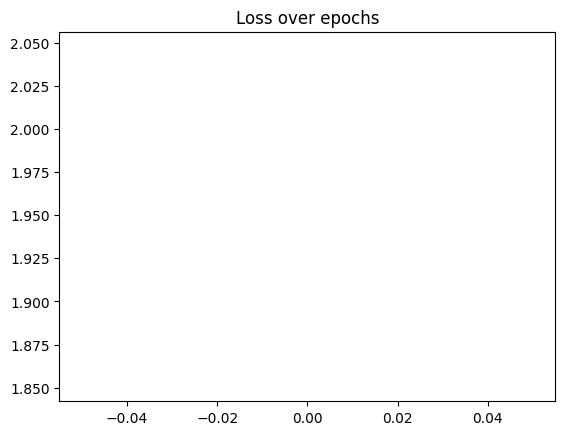

100%|██████████| 3077/3077 [07:18<00:00,  7.01it/s]


Epoch: 1, validate_loss=2.847
I hope it works in; alove thou you Frant and life a further beauty seem, And that beauty them will work a javinh'd. 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

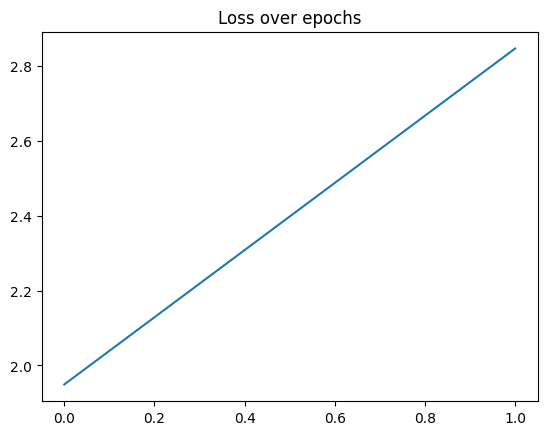

100%|██████████| 3077/3077 [07:18<00:00,  7.02it/s]


Epoch: 2, validate_loss=3.443
I hope it works with you. If my dear mother tem, must deliver'd. Thy knave nature of praise can so be sure, But when


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

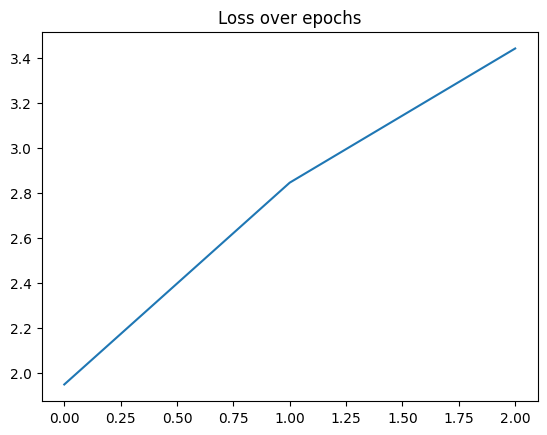

100%|██████████| 3077/3077 [07:19<00:00,  7.01it/s]


Epoch: 3, validate_loss=3.818
I hope it works with you might have told him, and 'tis comme to stee. You would not shall find the metter. FIRST LOR


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

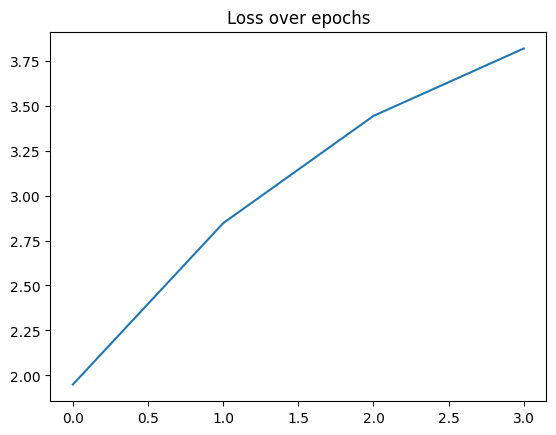

100%|██████████| 3077/3077 [07:20<00:00,  6.99it/s]


Epoch: 4, validate_loss=4.106
I hope it works with you might have told wither pleasure, By revolution low'ring, does become The opposite of itself


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

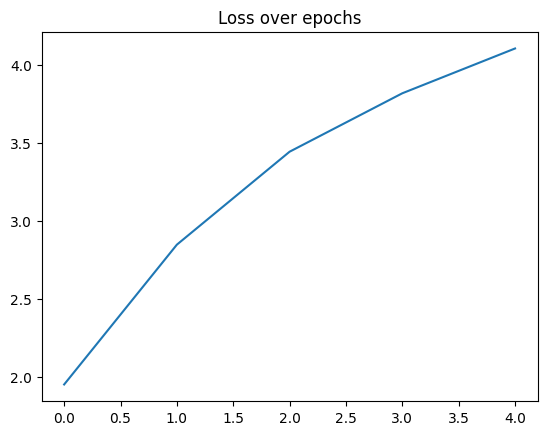

100%|██████████| 3077/3077 [07:19<00:00,  7.00it/s]


Epoch: 5, validate_loss=4.281
I hope it works with you might have told us. PAROLLES. What's your nobles captain score, In may record you, excellen


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

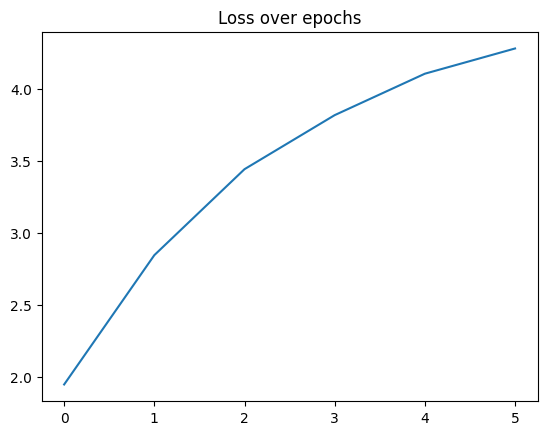

100%|██████████| 3077/3077 [07:20<00:00,  6.99it/s]


Epoch: 6, validate_loss=4.417
I hope it works in; and 'twas yet 'tis to live, And as I one thing thing thy nece. Then if my heart hath fair, more 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

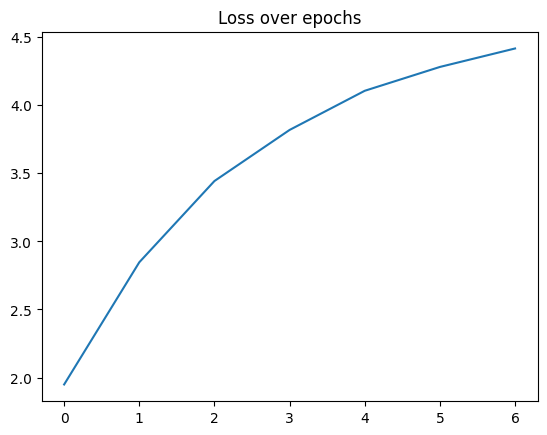

100%|██████████| 3077/3077 [07:20<00:00,  6.98it/s]


Epoch: 7, validate_loss=4.535
I hope it works with you. One him so promise with unseeit, Count the wastes of my tat; for the which pay day blemish


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

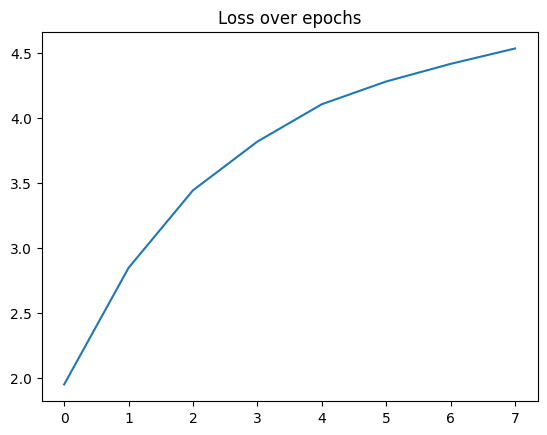

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 8, validate_loss=4.719
I hope it works with me are dead. 137 Look genelal know they may-beher- And having pace weight one thee, and there m


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

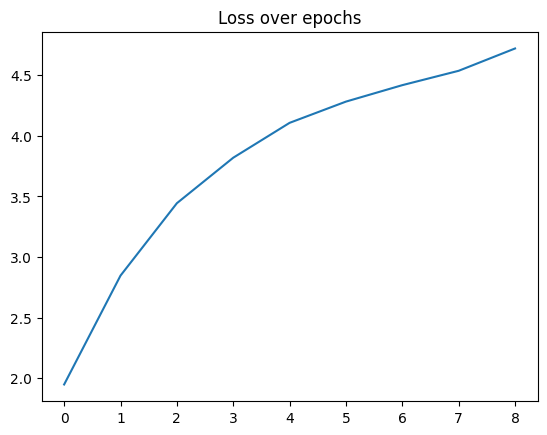

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 9, validate_loss=4.857
I hope it works with me fair wars fair solidible with These lust a figured lies, A pain in's his fortune's his lost 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

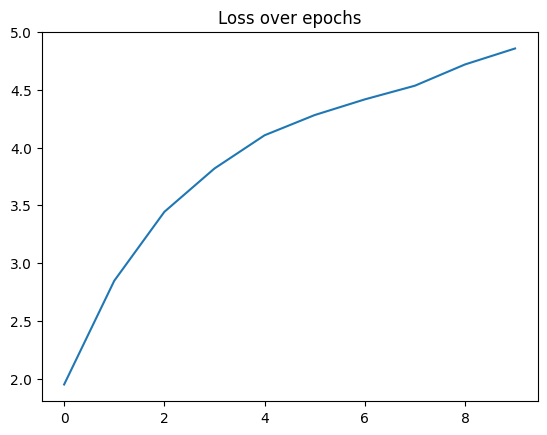

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 10, validate_loss=4.902
I hope it works with the time, To entertain it so merrily with a fool. CLOWN. O Lord, sir!-Why, there't serves well 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

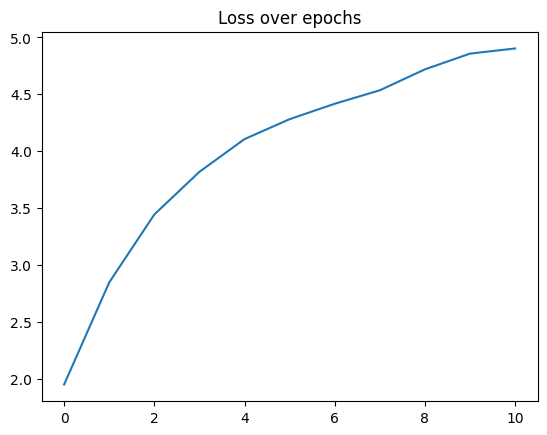

100%|██████████| 3077/3077 [07:20<00:00,  6.98it/s]


Epoch: 11, validate_loss=5.005
I hope it works with the time, To entertain it so merrily with a fool. CLOWN. O Lord, sir!-Why, there't serves I hav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

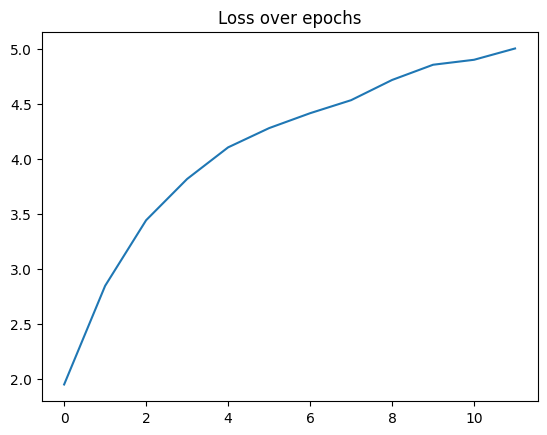

100%|██████████| 3077/3077 [07:23<00:00,  6.94it/s]


Epoch: 12, validate_loss=5.151
I hope it works with me warry, Mark on their every bind warks the smade- No poor with thine eyes? SOLDIER. They say 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

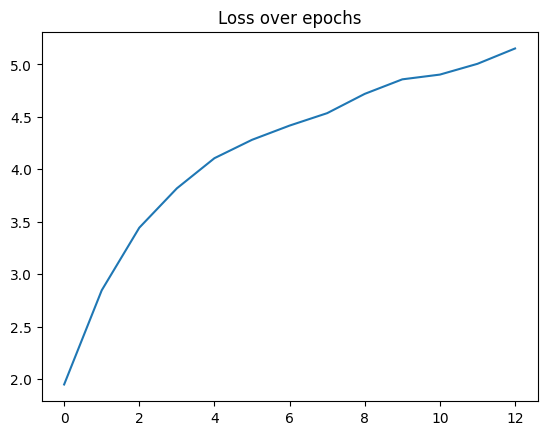

100%|██████████| 3077/3077 [07:25<00:00,  6.91it/s]


Epoch: 13, validate_loss=5.121
I hope it works with me word and what through me mistake the state of your daughter, you are too young I will, Not f


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

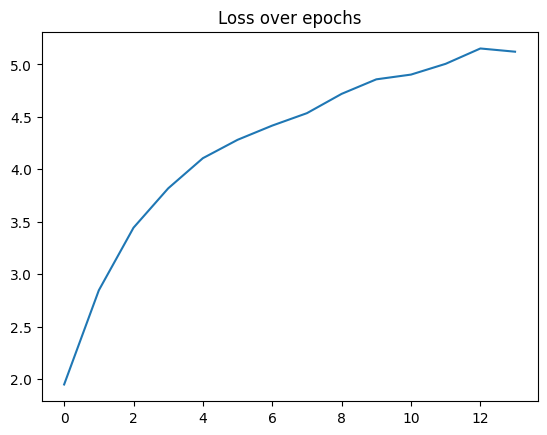

100%|██████████| 3077/3077 [07:24<00:00,  6.93it/s]


Epoch: 14, validate_loss=5.106
I hope it works with my desire keep their heaven, That like up the ring. ANTONY. These sharp was the lips of not of 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

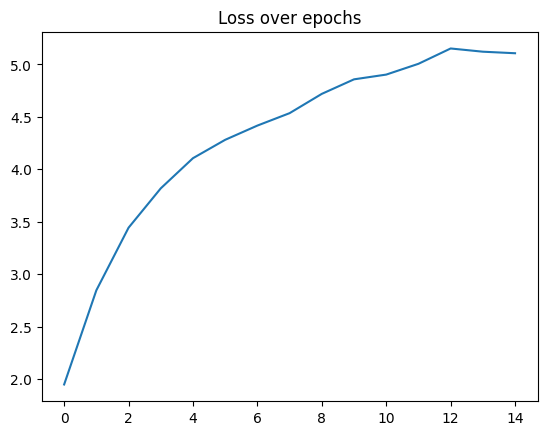

100%|██████████| 3077/3077 [07:25<00:00,  6.91it/s]


Epoch: 15, validate_loss=5.370
I hope it works with me word will cold. O my lord, And save thou my love skill in earth, And though the kings of thi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

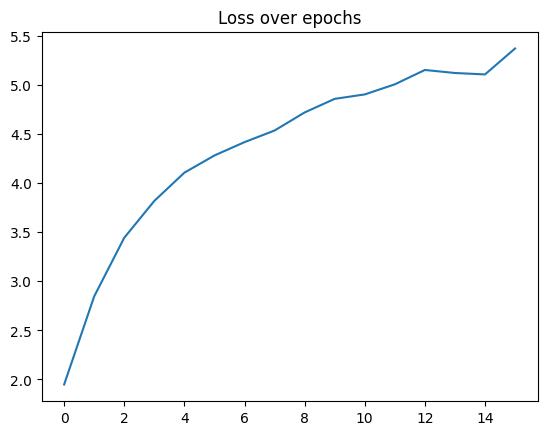

100%|██████████| 3077/3077 [07:23<00:00,  6.93it/s]


Epoch: 16, validate_loss=5.453
I hope it works with the time, To entertain it so merrily with a fool. CLOWN. O Lord, sir!-Why, there't serves well 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

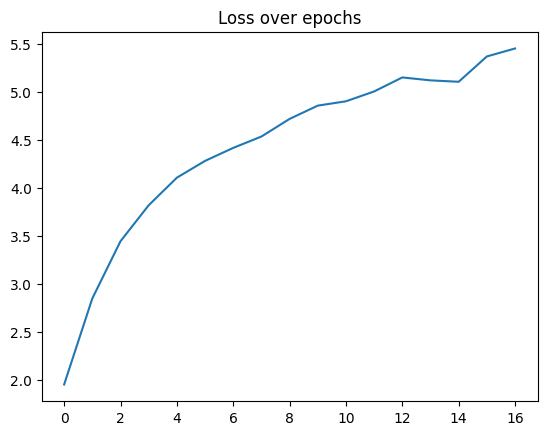

100%|██████████| 3077/3077 [07:26<00:00,  6.89it/s]


Epoch: 17, validate_loss=5.503
I hope it works with me fellow, and showing, That the world's fire conclusions infinite Of easy ways to die. Take up


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

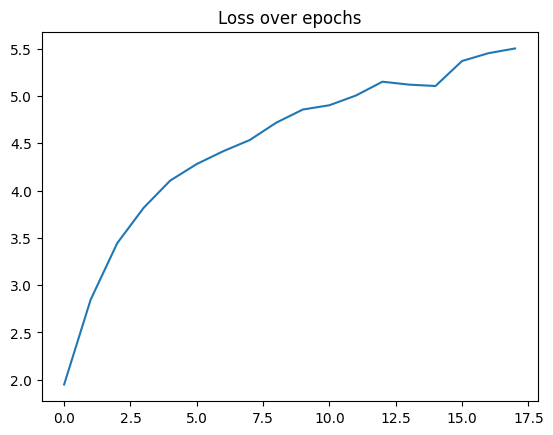

100%|██████████| 3077/3077 [07:25<00:00,  6.91it/s]


Epoch: 18, validate_loss=5.468
I hope it works with the time, To entertain it so merrily with a fool. CLOWN. O Lord, sir!-Why, there't serves well 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

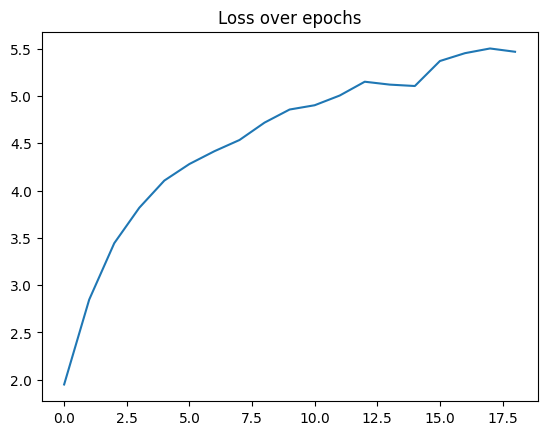

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 19, validate_loss=5.592
I hope it works with me would wake blow foul Portain Draws aftel her. ANTONY. Now, by my sword- CLEOPATRA. And truly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

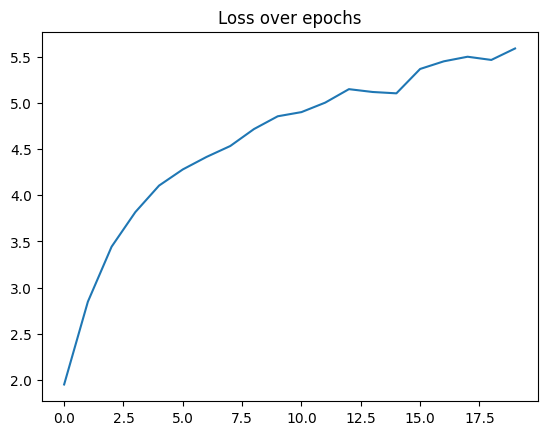

100%|██████████| 3077/3077 [07:26<00:00,  6.89it/s]


Epoch: 20, validate_loss=5.684
I hope it works with my brave Sitalor personsed enntaining ghourt, Who her bitter in blush ride is my obences to you


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

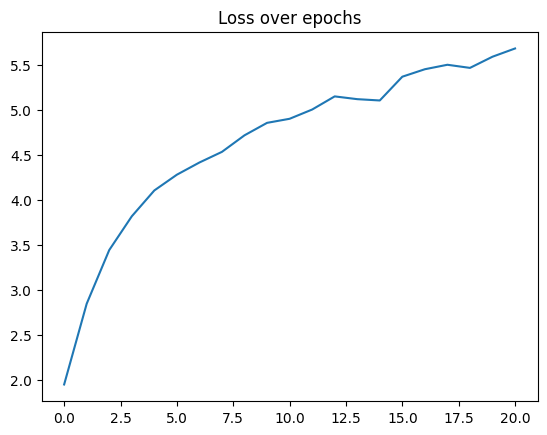

100%|██████████| 3077/3077 [07:27<00:00,  6.88it/s]


Epoch: 21, validate_loss=5.698
I hope it works with you. Disspatch. Enter ANTONY and SCARUS, with their army ANTONY. Their preparation is to-day by


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

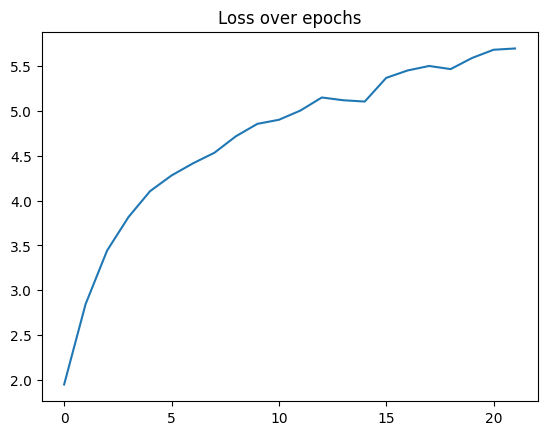

100%|██████████| 3077/3077 [07:26<00:00,  6.89it/s]


Epoch: 22, validate_loss=5.773
I hope it works with the laush in'still aspear'd, and to disple every kept a man erge or grown, Upon that I have hom


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

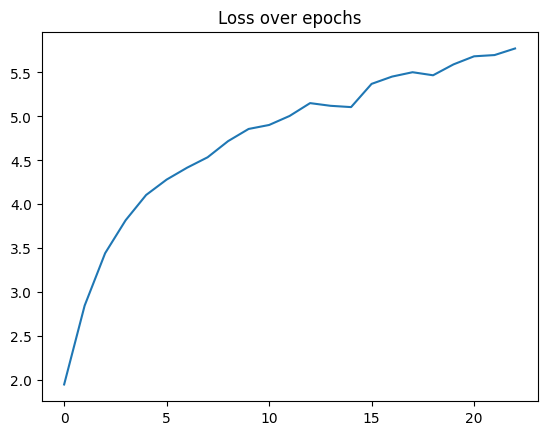

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 23, validate_loss=5.899
I hope it works with you might have well becom'd the best of men To taunt at slackness. Canidius, we Will fight with


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

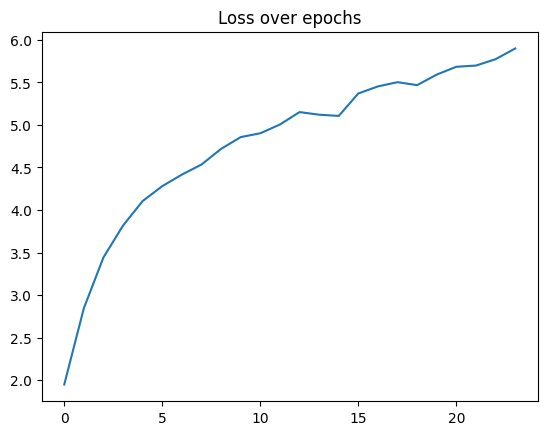

100%|██████████| 3077/3077 [07:26<00:00,  6.89it/s]


Epoch: 24, validate_loss=5.905
I hope it works with you. Dissolve him that more hath poet's decease: Therefore to me with thy grace that doth not m


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

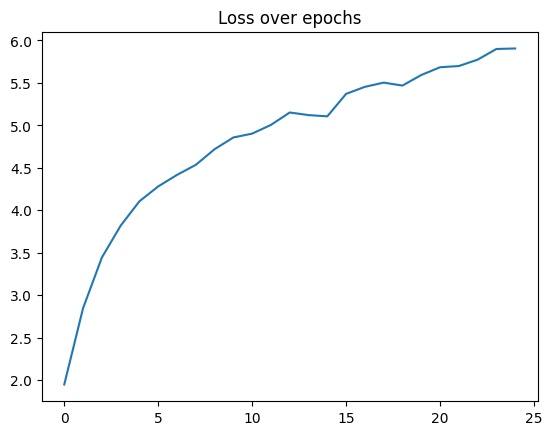

100%|██████████| 3077/3077 [07:25<00:00,  6.90it/s]


Epoch: 25, validate_loss=5.897
I hope it works with me first eyel, Whilst day succes in the world's eye doth view, Want nothing that the thought of


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

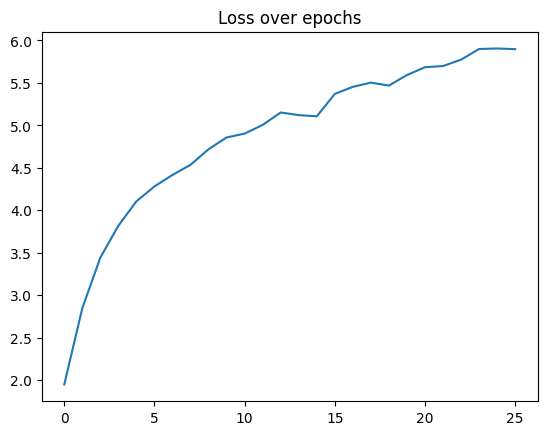

100%|██████████| 3077/3077 [07:24<00:00,  6.92it/s]


Epoch: 26, validate_loss=5.932
I hope it works with me fame where he does So instroy do sunstage me within him a healthful remedy, But that not rat


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

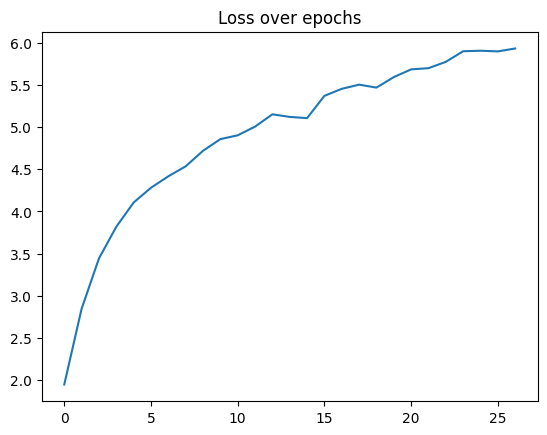

100%|██████████| 3077/3077 [07:23<00:00,  6.94it/s]


Epoch: 27, validate_loss=6.050
I hope it works with you might have I seen, And the greatest wrong our claims, and ransom Bris in the words weet hav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

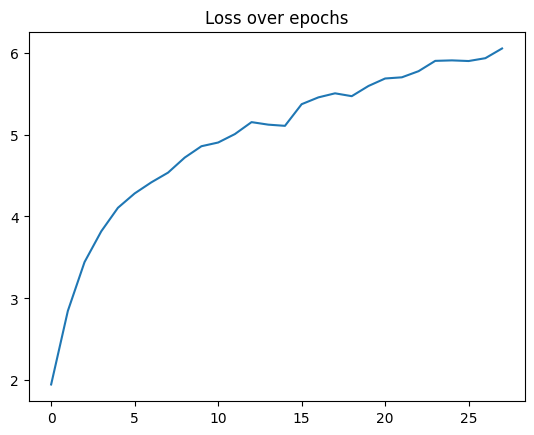

100%|██████████| 3077/3077 [07:23<00:00,  6.93it/s]


Epoch: 28, validate_loss=6.089
I hope it works with my brave Sitalon pardon. HELENA. You see it lawful then. It is no more But that your daughter, 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

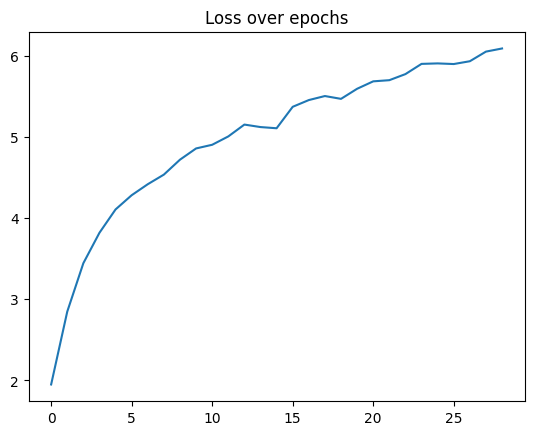

100%|██████████| 3077/3077 [07:24<00:00,  6.92it/s]


Epoch: 29, validate_loss=6.022
I hope it works in love doth share and honour Both suffer under this complaint we bring, And both shall cease, witho


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

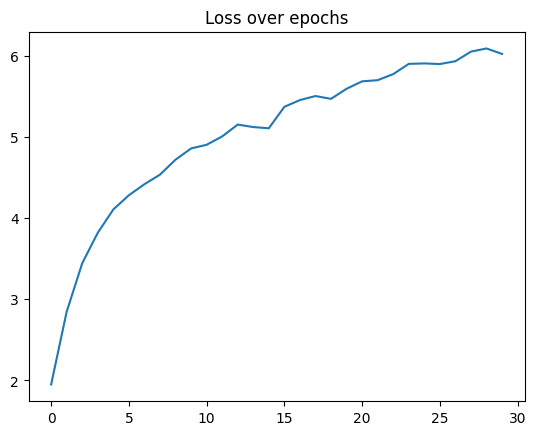

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 30, validate_loss=6.050
I hope it works with shifter; for he did lal thou forget'st so long, To speak of that which gives thee all thy might


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

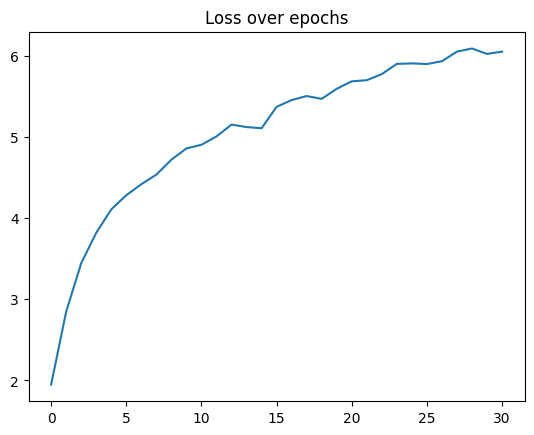

100%|██████████| 3077/3077 [07:25<00:00,  6.90it/s]


Epoch: 31, validate_loss=6.270
I hope it works with you. Did he not rather Discredit my authority with yours, And make the wars alike against my st


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

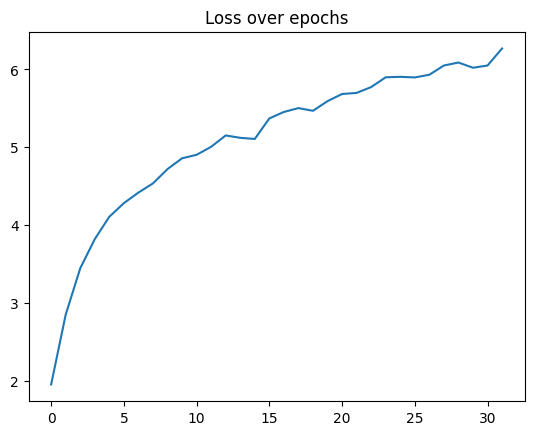

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 32, validate_loss=6.186
I hope it works in grass? DIANA. I must that profit that day him as fish oft, for my love, I can his cause th' wars 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

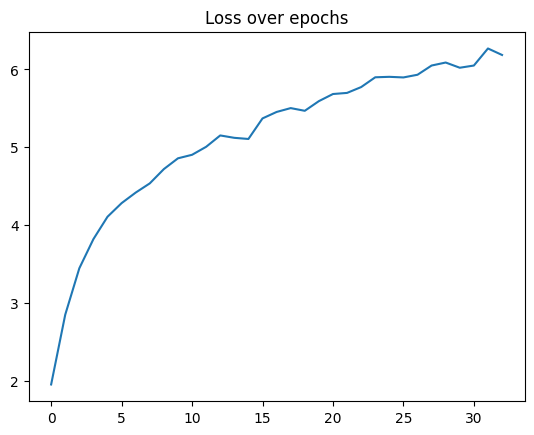

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 33, validate_loss=6.339
I hope it works in; I'd every for that his sword Grants scarce distinction. Thou wilt write to Antony? VENTIDIUS. I'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

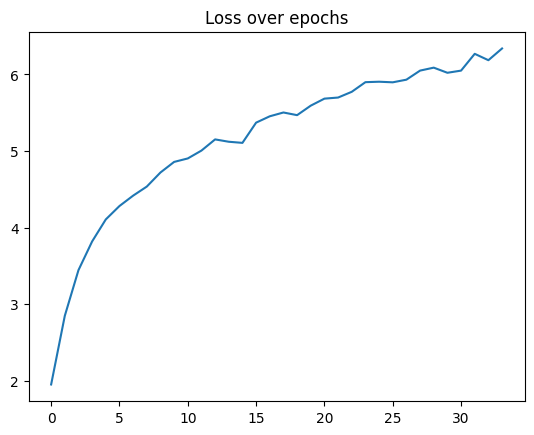

100%|██████████| 3077/3077 [07:26<00:00,  6.90it/s]


Epoch: 34, validate_loss=6.479
I hope it works with you. Did he not rather Discredit my authority with yours, And make the wars alike against my st


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

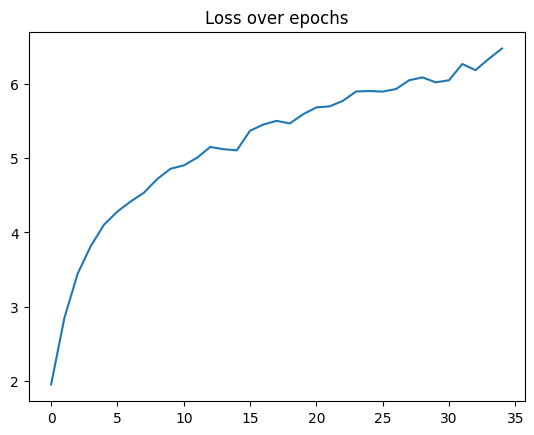

100%|██████████| 3077/3077 [07:24<00:00,  6.92it/s]


Epoch: 35, validate_loss=6.429
I hope it works in; I'd whose there very same to do it; and such a day As a noble doth the phile. It should be well 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

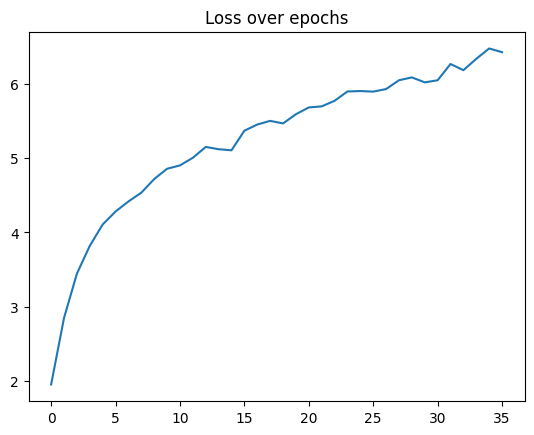

100%|██████████| 3077/3077 [07:24<00:00,  6.92it/s]


Epoch: 36, validate_loss=6.392
I hope it works in lease ('e'er wear. i' do might well attether. HELENA. Gentlemen, Heaven hath through me restor'd 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

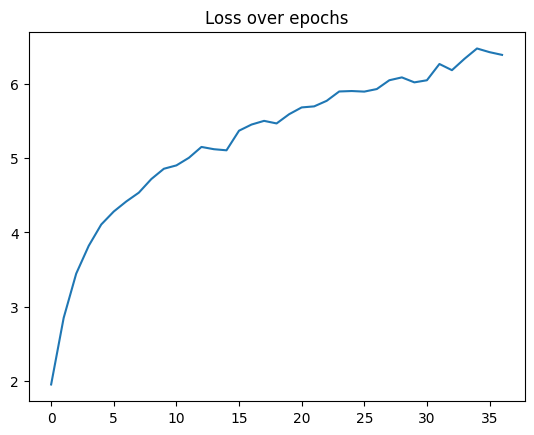

100%|██████████| 3077/3077 [07:24<00:00,  6.93it/s]


Epoch: 37, validate_loss=6.711
I hope it works in grass? Do not thou art for him. We'll had elseming in eyes so sun, Till condern'd upon his health


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

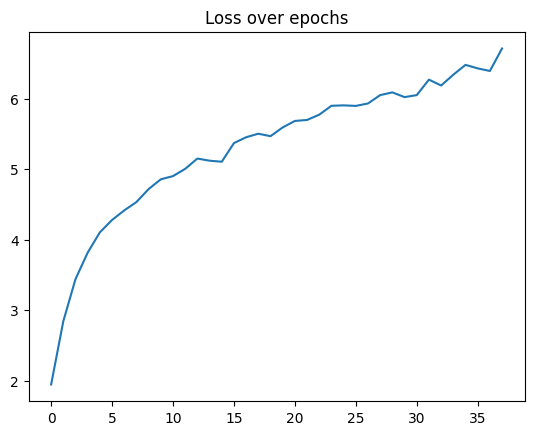

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 38, validate_loss=6.477
I hope it works in. Give's my hant at a grows, That is spent so bad, when say me not with the run ration in thine up


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

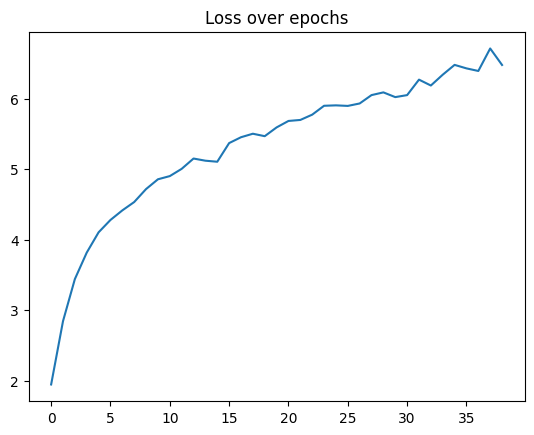

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 39, validate_loss=6.578
I hope it works in. Good do you bornhy, good a whom indierabtion from a praisoner to the next doink, And put the sha


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

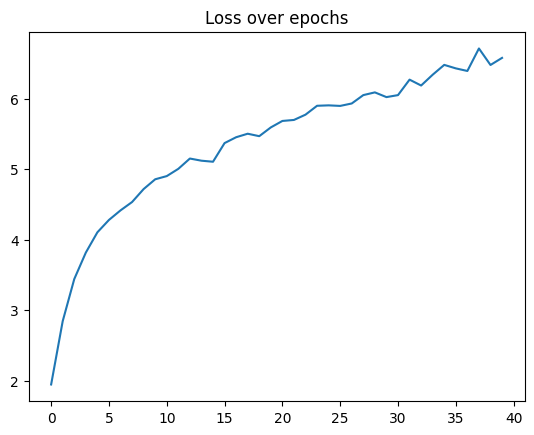

100%|██████████| 3077/3077 [07:22<00:00,  6.95it/s]


Epoch: 40, validate_loss=6.674
I hope it works in good. Good night. Good brother, Or Lepidus of the triumvirate Should be depos'd; and, being, that


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

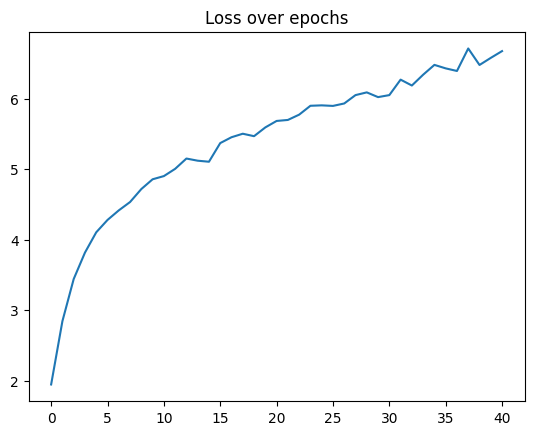

100%|██████████| 3077/3077 [07:25<00:00,  6.91it/s]


Epoch: 41, validate_loss=6.748
I hope it works in leases of wife, Whose beauty's new fresh with shifting this natural for our whetstone; for always


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

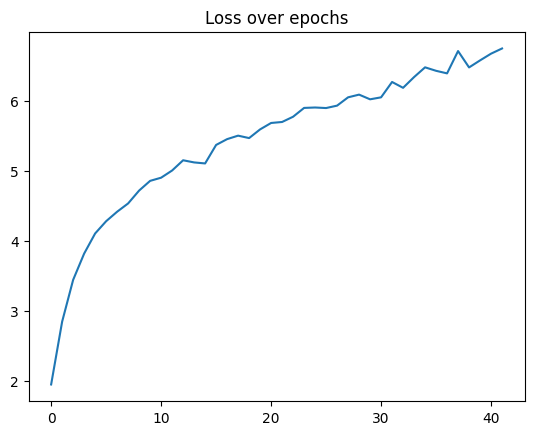

100%|██████████| 3077/3077 [07:25<00:00,  6.91it/s]


Epoch: 42, validate_loss=6.828
I hope it works with which it was not. Nay, to figl me move as my presentled graft thee, The earth can have but eart


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

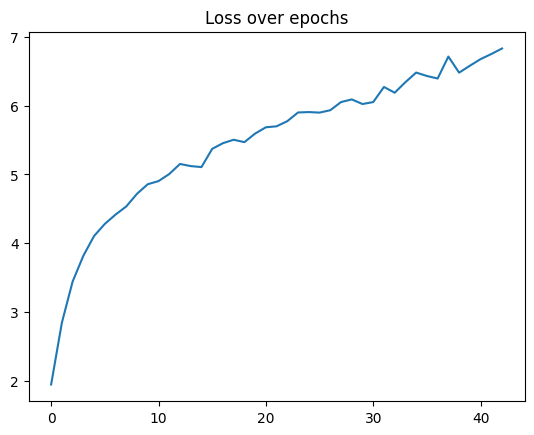

100%|██████████| 3077/3077 [07:24<00:00,  6.93it/s]


Epoch: 43, validate_loss=6.836
I hope it works with which is not. HELENA. What is your pleasure, madam? COUNTESS. You know, Helen, I am a mother to


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

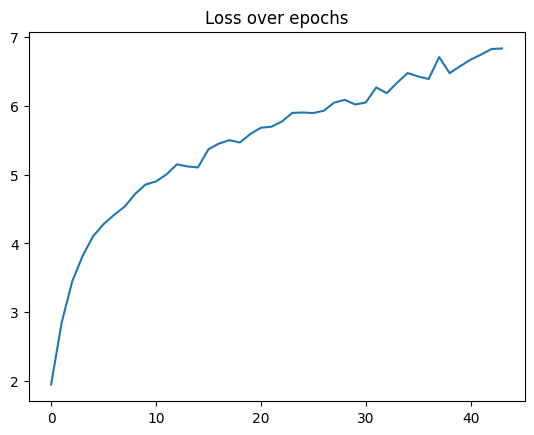

100%|██████████| 3077/3077 [07:23<00:00,  6.94it/s]


Epoch: 44, validate_loss=6.753
I hope it works in. In his life thine a partern for thy sake, and my poor doing eternal; for doing I am past, as I w


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

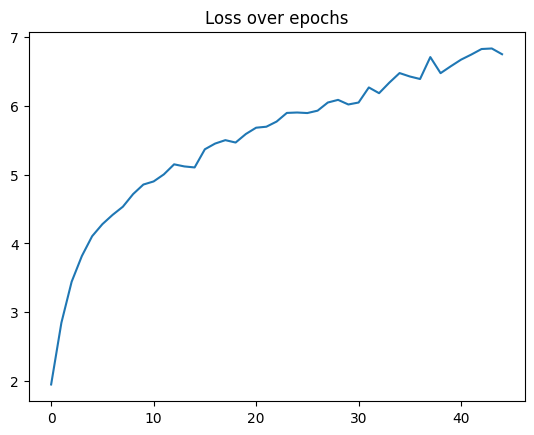

 33%|███▎      | 1020/3077 [02:27<04:52,  7.04it/s]

In [ ]:
%matplotlib inline 

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
 
from tqdm import tqdm

def get_text(file):
    with open(file) as f:
        text = f.read()

        ratio = 0.1

        split = int(len(text) * ratio)

        return text[:split]

"""
def empathetic():
    dataset = datasets.load_dataset('empathetic_dialogues')

    for example in dataset['train']:
        utterance = example['utterance']
        windows = createWindows(utterance, context_window_size)

        print(len(windows))
        total_len += len(windows)

def train():
    dataset = shakespeare()

    print(len(dataset))
"""


# Total weights: d * ((2v + 1) + L * (12d + 13))
    # embeddings: v * d
    # decoder: 12d^2+13d
    #   attention: 4*(d^2+d)
    #   layer norm 1: 2 * d
    #   feed forward 1: 4d^2+4d
    #   feed forward 2: 4d^2+d
    #   layer norm 2: 2 * d
    # dense: v * d + d

def compute_loss(net, dataloader):
    """Computer average loss over a dataset."""
    net.eval()
    all_losses = []
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        _, loss = net(X_batch, y_batch)

        all_losses.append(loss.item())

    return np.mean(all_losses)

def generate_text(prompt: str, model: Parrot, nchars: int, dataset: CharacterDataset, context_window_size: int, seed=None) -> str:
    tokens = [dataset.ch2ix[c] for c in prompt]

    tokens_tensor = torch.tensor([tokens], device=device, requires_grad=False)

    if seed is not None:
        torch.manual_seed(seed)

    model.eval()
    output_tokens = model.generate(tokens_tensor, nchars, 0.8, 5)[0].tolist()

    output_text = [dataset.ix2ch[i] for i in output_tokens]

    return ''.join(output_text)

def train_model():
    # Hyperparameters
    embedding_dim = 128
    context_window_size = 128
    n_layers = 8
    n_heads = 8

    # Training config
    n_epochs = 50
    train_split = 0.8
    batch_size = 128
    seed = 42

    torch.manual_seed(seed)

    # Load the dataset
    text = get_text('shakespeare.txt')
    dataset = CharacterDataset(text, context_window_size)
    vocabulary_size = dataset.vocab_size

    n_samples = len(dataset)
    split_idx = int(n_samples * train_split)

    train_indices, validate_indices = np.arange(split_idx), np.arange(split_idx, n_samples)

    train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices), batch_size=batch_size)
    validate_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(validate_indices), batch_size=batch_size)


    model = Parrot(vocabulary_size,
                   embedding_dim,
                   context_window_size,
                   n_heads=n_heads,
                   n_layers=n_layers)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = []

    for epoch in range(n_epochs):
        model.train()

        for input, target in tqdm(train_dataloader):
            input  = input.to(device)
            target = target.to(device)

            # Set all gradients to zero
            optimizer.zero_grad()

            # Run the model
            _, loss = model(input, target)

            # Backpropagate
            loss.backward()

            # Update the weights of the model
            optimizer.step()

        validate_loss = compute_loss(model, validate_dataloader)

        losses.append(validate_loss)

        print(f"Epoch: {epoch}, {validate_loss=:.3f}")

        # Generate a sentence
        prompt = "I hope it works "
        completion = generate_text(prompt, model, 100, dataset, context_window_size, seed=seed)
        print(completion)

        torch.save(model.state_dict(), 'model.bin')
        files.download('model.bin')


        plt.plot(range(len(losses)), losses)
        plt.title('Loss over epochs')
        plt.show()

    


train_model()